# Classifer Network

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from datasets import show_images, print_tensor_stats

Matplotlib created a temporary cache directory at /tmp/matplotlib-rfcl82ns because the default path (/teamspace/studios/this_studio/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Datasets

In [2]:
from datasets import EmnistDataset, EmnistMapping, emnist_transform, FontDataset, font_transform, augmentations, GanDataset, gan_transform, augmented_gan_transform, augmented_font_transform
from config import EMNIST_TRAIN_PATH, EMNIST_TEST_PATH, EMNIST_MAPPING_PATH, FONTS_DATASET_PATH, FONTS_MAPPING_PATH, GAN_DATASET_PATH, GAN_MAPPING_PATH

In [3]:
test_dataset = EmnistDataset(EMNIST_TEST_PATH, emnist_transform, limit=1024)
print("Shape:", test_dataset[0][0].shape)
print_tensor_stats(test_dataset[0][0], "TEST")

Shape: torch.Size([1, 28, 28])
TEST: min=-1.0, max=1.0, mean=-0.5457882881164551, std=0.754500687122345


In [4]:
emnist_dataset = EmnistDataset(EMNIST_TRAIN_PATH, emnist_transform, limit=128)
emnist_mapping = EmnistMapping(EMNIST_MAPPING_PATH)
print("Shape:", emnist_dataset[0][0].shape)
print_tensor_stats(emnist_dataset[0][0], "EMNIST")

Shape: torch.Size([1, 28, 28])
EMNIST: min=-1.0, max=1.0, mean=-0.7041115760803223, std=0.6117731928825378


In [4]:
font_dataset = FontDataset(FONTS_DATASET_PATH, FONTS_MAPPING_PATH, font_transform)
print("Shape:", font_dataset[0][0].shape)
print_tensor_stats(font_dataset[0][0], "Font")

Shape: torch.Size([1, 28, 28])
Font: min=-1.0, max=0.9998000860214233, mean=-0.755046546459198, std=0.5768011212348938


In [5]:
augmented_font_dataset = FontDataset(FONTS_DATASET_PATH, FONTS_MAPPING_PATH, augmented_font_transform)
print("Shape:", augmented_font_dataset[0][0].shape)
print_tensor_stats(augmented_font_dataset[0][0], "Augmented Font")

Shape: torch.Size([1, 28, 28])
Augmented Font: min=-0.9843152761459351, max=0.6861059665679932, mean=-0.6516954898834229, std=0.46975699067115784


In [6]:
augmented_dataset = EmnistDataset(EMNIST_TRAIN_PATH, augmentations, limit=2048)
print("Shape:", augmented_dataset[0][0].shape)
print_tensor_stats(augmented_dataset[0][0], "Augmented")

Shape: torch.Size([1, 28, 28])
Augmented: min=-1.0, max=0.995802640914917, mean=-0.455932080745697, std=0.7531977891921997


In [3]:
gan_dataset = GanDataset(GAN_DATASET_PATH, GAN_MAPPING_PATH, transform=gan_transform, limit=2048)
print("Shape:", gan_dataset[0][0].size())
print_tensor_stats(gan_dataset[0][0], "GAN")

Shape: torch.Size([1, 28, 28])
GAN: min=-1.0, max=0.9998000860214233, mean=-0.6418124437332153, std=0.7037144899368286


In [8]:
augmented_gan_dataset = GanDataset(GAN_DATASET_PATH, GAN_MAPPING_PATH, transform=augmented_gan_transform)
print("Shape:", augmented_gan_dataset[0][0].size())
print_tensor_stats(augmented_gan_dataset[0][0], "GAN")

Shape: torch.Size([1, 28, 28])
GAN: min=-1.0, max=0.9213765859603882, mean=-0.32952880859375, std=0.6960970759391785


8


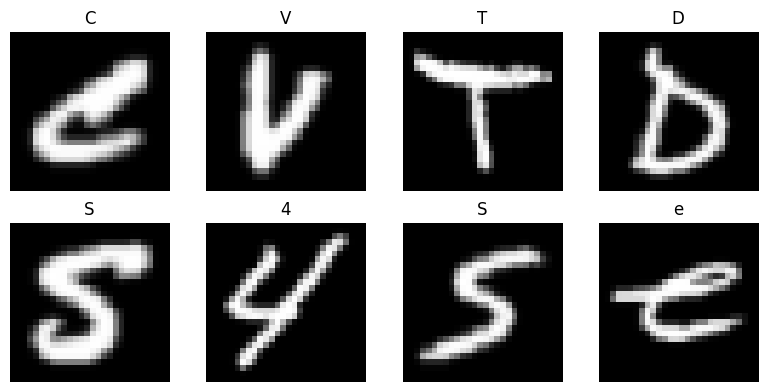

In [10]:
show_images(emnist_dataset[:8], 2, mapping=emnist_mapping.mapping)

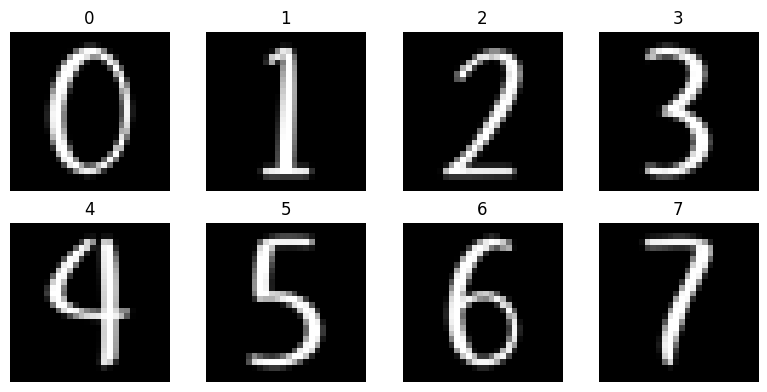

In [8]:
show_images(font_dataset[:8], 2, mapping=font_dataset.mapping)

8


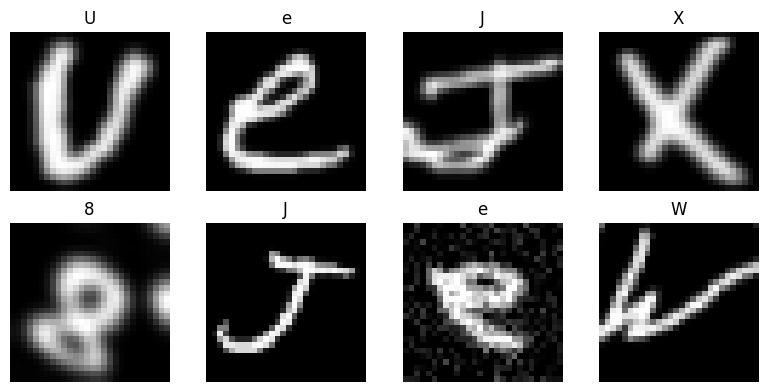

In [22]:
show_images(augmented_dataset[:8], 2, mapping=emnist_mapping.mapping)

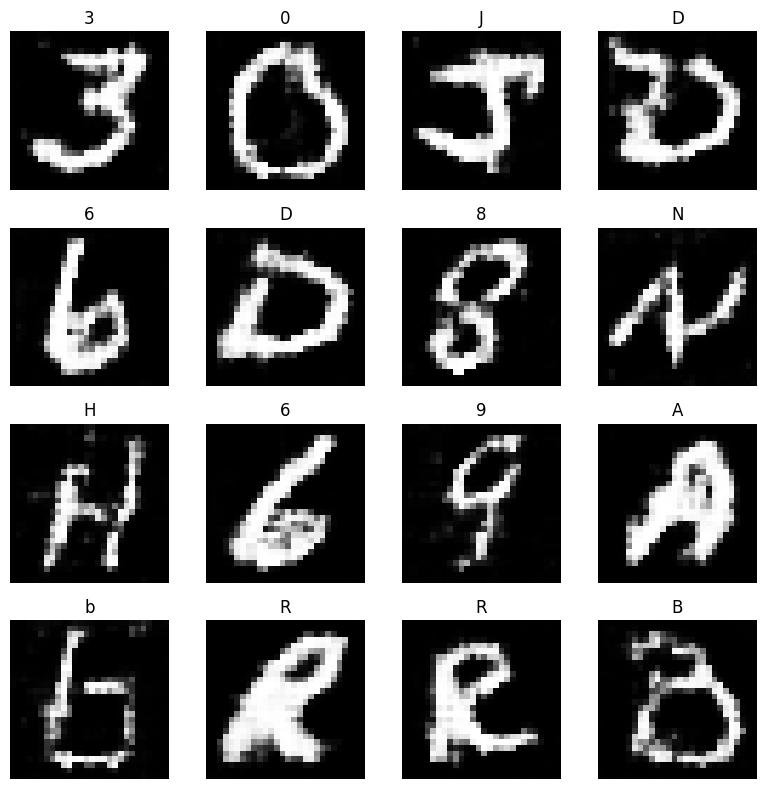

In [4]:
show_images(gan_dataset[:16], 4, gan_dataset.mapping)

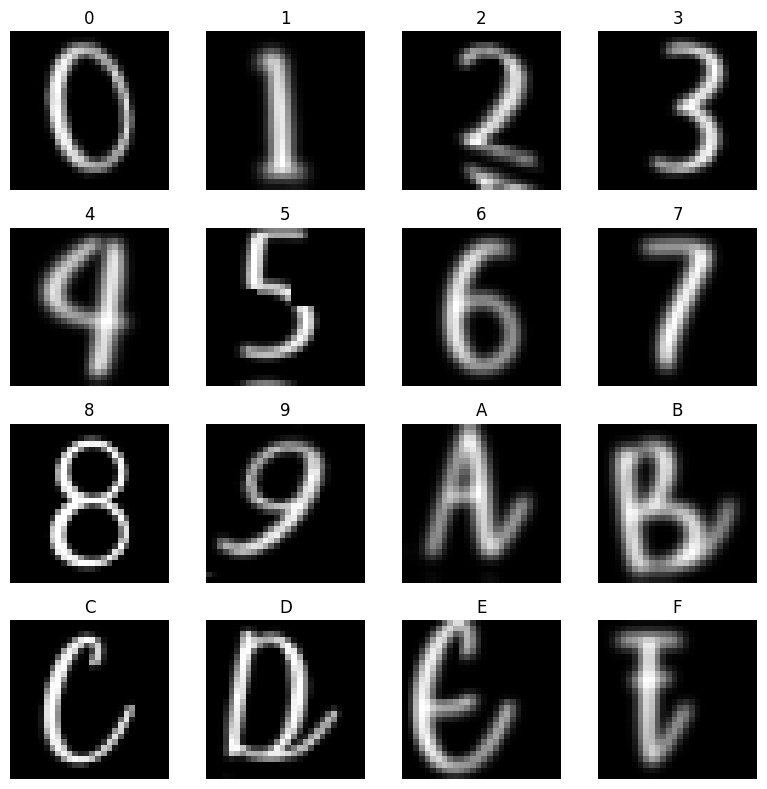

In [10]:
show_images(augmented_font_dataset[:16], 4, augmented_font_dataset.mapping)

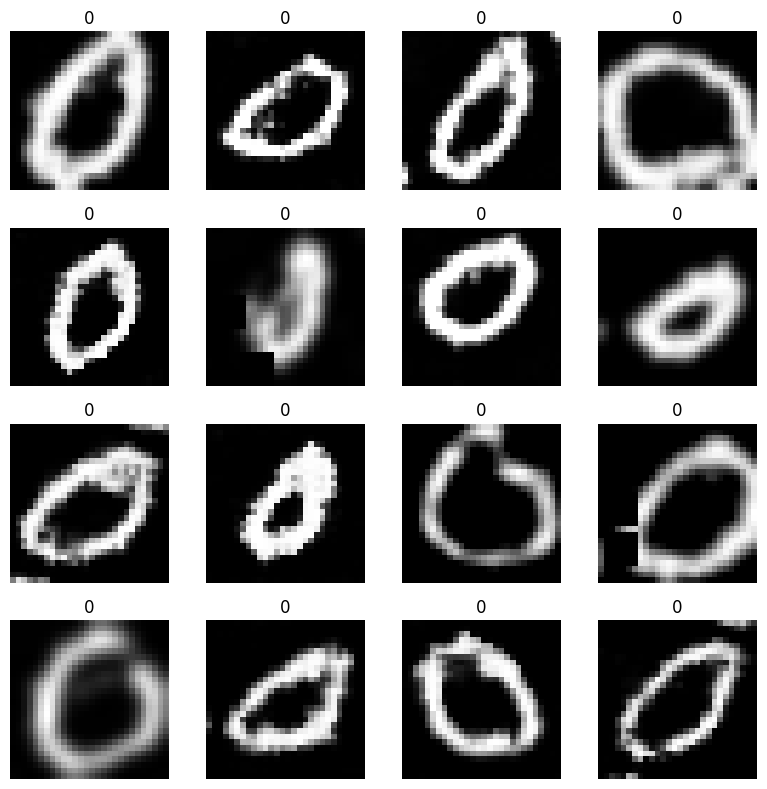

In [9]:
show_images(augmented_gan_dataset[:16], 4, augmented_gan_dataset.mapping)

## Network Initialisation

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class ClassifierNetwork(nn.Module):
    def __init__(self, num_classes=10, dropout_prob=0.5, hidden_layer=32):
        super(ClassifierNetwork, self).__init__()
        self.hidden_layer = hidden_layer
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, hidden_layer, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(dropout_prob)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(hidden_layer, hidden_layer * 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(dropout_prob)
        )
        self.fc_block = nn.Sequential(
            nn.Linear(hidden_layer * 2 * 7 * 7, 3 * hidden_layer),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(3 * hidden_layer, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(-1, self.hidden_layer * 2 * 7 * 7)
        x = self.fc_block(x)
        return x

In [12]:
# current_train_size = 64 * (2 ** 10)
num_epochs = 1000
dropout_prob = 0.0
hidden_layer_size = 32
batch_size = 64
lr = 0.001

In [13]:
augmentation_loader = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)
font_loader = DataLoader(font_dataset, batch_size=batch_size, shuffle=True)
augmented_font_loader = DataLoader(augmented_font_dataset, batch_size=batch_size, shuffle=True)
gan_loader = DataLoader(gan_dataset, batch_size=batch_size, shuffle=True)
augmented_gan_loader = DataLoader(augmented_gan_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ClassifierNetwork(num_classes=47, dropout_prob=dropout_prob, hidden_layer=hidden_layer_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# writer = SummaryWriter(f'runs/experiment_hds_{hidden_layer_size}_ts_{current_train_size}_dp_{dropout_prob}')
writer = SummaryWriter(f'runs/augmentation+gan')

In [15]:
def calculate_metrics(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    accuracy = accuracy_score(labels.cpu().numpy(), predicted.cpu().numpy())
    precision = precision_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='macro', zero_division=0)
    recall = recall_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='macro', zero_division=0)
    f1 = f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='macro', zero_division=0)
    return accuracy, precision, recall, f1

In [16]:
def train_and_evaluate(epoch, train_loader, test_loader):
    model.train()
    total_train_loss = 0
    total_test_loss = 0
    train_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        
        # Calculate training metrics
        acc, prec, rec, f1 = calculate_metrics(outputs, labels)
        train_metrics['accuracy'].append(acc)
        train_metrics['precision'].append(prec)
        train_metrics['recall'].append(rec)
        train_metrics['f1'].append(f1)

    # Log training metrics
    writer.add_scalar('Loss/Train', total_train_loss / len(train_loader), epoch)
    writer.add_scalar('Accuracy/Train', np.mean(train_metrics['accuracy']), epoch)
    writer.add_scalar('Precision/Train', np.mean(train_metrics['precision']), epoch)
    writer.add_scalar('Recall/Train', np.mean(train_metrics['recall']), epoch)
    writer.add_scalar('F1/Train', np.mean(train_metrics['f1']), epoch)

    # Evaluate on the test set
    model.eval()
    test_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_loss = criterion(outputs, labels)
            total_test_loss += test_loss.item()
            acc, prec, rec, f1 = calculate_metrics(outputs, labels)
            test_metrics['accuracy'].append(acc)
            test_metrics['precision'].append(prec)
            test_metrics['recall'].append(rec)
            test_metrics['f1'].append(f1)

    # Log test metrics
    writer.add_scalar('Loss/Test', total_test_loss / len(test_loader), epoch)
    writer.add_scalar('Accuracy/Test', np.mean(test_metrics['accuracy']), epoch)
    writer.add_scalar('Precision/Test', np.mean(test_metrics['precision']), epoch)
    writer.add_scalar('Recall/Test', np.mean(test_metrics['recall']), epoch)
    writer.add_scalar('F1/Test', np.mean(test_metrics['f1']), epoch)

    return total_train_loss / len(train_loader), total_test_loss / len(test_loader)

# last_loss = float('inf')


## Training

In [19]:
for epoch in range(num_epochs):
    train_loss, test_loss = train_and_evaluate(epoch, augmented_gan_loader, test_loader)
    print(f"Epoch: {epoch}, Train loss: {train_loss}, Test loss: {test_loss}")
    # if loss >= last_loss - 0.01:  # Continue if loss decreases, even slightly
    #     break
    # last_loss = loss

print("Finished Training")
writer.close()

Epoch: 0, Train loss: 2.90968057830283, Test loss: 1.8547512218356133
Epoch: 1, Train loss: 1.53125055800093, Test loss: 1.3478110022842884
Epoch: 2, Train loss: 1.0856978024574035, Test loss: 1.1949331536889076
Epoch: 3, Train loss: 0.9402051143189694, Test loss: 1.1704700700938702
Epoch: 4, Train loss: 0.8171887388254734, Test loss: 1.1443800367414951
Epoch: 5, Train loss: 0.7304855439257114, Test loss: 1.1636592037975788
Epoch: 6, Train loss: 0.6992988082322669, Test loss: 1.073307428508997
Epoch: 7, Train loss: 0.6523911949801953, Test loss: 1.110926192253828
Epoch: 8, Train loss: 0.6303569569866708, Test loss: 1.0916734784841537
Epoch: 9, Train loss: 0.6210615951964196, Test loss: 1.1133452542126179
Epoch: 10, Train loss: 0.5912293623736564, Test loss: 1.1166372299194336
Epoch: 11, Train loss: 0.57230651346927, Test loss: 1.0683836340904236
Epoch: 12, Train loss: 0.5475641817171523, Test loss: 1.1563502065837383
Epoch: 13, Train loss: 0.527988870093163, Test loss: 1.11089527234435